In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

In [3]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

batch_size = 64

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In [4]:
class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(noise_dim, 512, 4, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.model(x)

In [5]:
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, stride=1, padding=0),
            nn.Flatten()
        )
    
    def forward(self, x):
        return self.model(x)

In [6]:
# set noise and initiate gen and critic
noise_dim = 100
generator = Generator(noise_dim).cuda()
critic = Critic().cuda()

# arrays for loss graphing
critic_losses = []
generator_losses = []

# using RMSProp and WGAN papers recommendations
g_optimizer = optim.RMSprop(generator.parameters(), lr=0.00005)
c_optimizer = optim.RMSprop(critic.parameters(), lr=0.00005)

# training, using WGAN paper recommendations for values
num_epochs = 50
critic_iterations = 5
clip_value = 0.01 

for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(train_loader):

        # traing the critic
        for _ in range(critic_iterations):
            noise = torch.randn(imgs.shape[0], noise_dim, 1, 1).cuda()
            fake_imgs = generator(noise)
            critic_real = critic(imgs.cuda()).reshape(-1)
            critic_fake = critic(fake_imgs).reshape(-1)
            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))
            c_optimizer.zero_grad()
            loss_critic.backward(retain_graph=True)
            c_optimizer.step()

            #clip the weights
            for p in critic.parameters():
                p.data.clamp_(-clip_value, clip_value)

        # Traing the generator
        generator.zero_grad()
        output = critic(fake_imgs).reshape(-1)
        loss_generator = -torch.mean(output)
        loss_generator.backward()
        g_optimizer.step()
        
        #save losses to array
        generator_losses.append(loss_generator.item())
        critic_losses.append(loss_critic.item())
        
        
    print(f"Epoch [{epoch+1}/{num_epochs}], Last batch: critic_loss: {loss_critic.item():.4f}, Loss Generator: {loss_generator.item():.4f}")
    
# Save the generator and critic
torch.save(generator.state_dict(), 'WGAN_generator.pth')
torch.save(critic.state_dict(), 'WGAN_critic.pth')

Epoch [1/50], Last batch: critic_loss: -1.5080, Loss Generator: 0.7585
Epoch [2/50], Last batch: critic_loss: -1.5468, Loss Generator: 0.7755
Epoch [3/50], Last batch: critic_loss: -1.5528, Loss Generator: 0.7783
Epoch [4/50], Last batch: critic_loss: -1.4429, Loss Generator: 0.7326
Epoch [5/50], Last batch: critic_loss: -1.4564, Loss Generator: 0.7330
Epoch [6/50], Last batch: critic_loss: -1.5299, Loss Generator: 0.7659
Epoch [7/50], Last batch: critic_loss: -0.0586, Loss Generator: 0.7154
Epoch [8/50], Last batch: critic_loss: -1.5487, Loss Generator: 0.7760
Epoch [9/50], Last batch: critic_loss: -1.5423, Loss Generator: 0.7726
Epoch [10/50], Last batch: critic_loss: -1.5531, Loss Generator: 0.7787
Epoch [11/50], Last batch: critic_loss: -1.5482, Loss Generator: 0.7772
Epoch [12/50], Last batch: critic_loss: -1.5425, Loss Generator: 0.7721
Epoch [13/50], Last batch: critic_loss: -1.5548, Loss Generator: 0.7793
Epoch [14/50], Last batch: critic_loss: -1.5537, Loss Generator: 0.7781
E

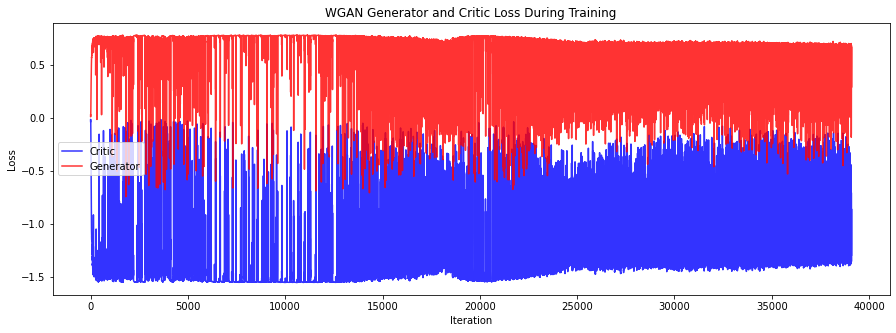

In [7]:
# Plotting the losses
plt.figure(figsize=(15, 5))
plt.title("WGAN Generator and Critic Loss During Training")
plt.plot(critic_losses, label='Critic', alpha=0.8, color='blue')
plt.plot(generator_losses, label='Generator', alpha=0.8, color='red')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

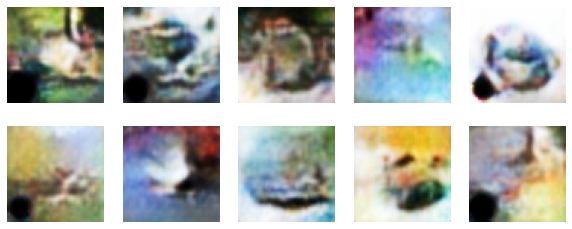

In [8]:
#generating 10 images for the final report
def generate_images(generator, noise_dim, num_images=10):
    
    generator.eval()
    noise = torch.randn(num_images, noise_dim, 1, 1, device='cuda')
    
    # generate images from the noise
    with torch.no_grad():
        generated_images = generator(noise)
        
    generated_images = generated_images.cpu().detach()
    return generated_images

#saving the images to a nice single png
def show_generated_images(generated_images, num_images=10):
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for ax, img in zip(axes.flatten(), generated_images):
        ax.axis('off')  # Hide axes
        img = torchvision.utils.make_grid(img, normalize=True)
        ax.imshow(img.permute(1, 2, 0))
    plt.savefig('WGAN_photos.png')
    plt.show()

#generate images and show them
generated_images = generate_images(generator, noise_dim=100, num_images=10)
show_generated_images(generated_images)

In [9]:
noise_dim = 100
generator = Generator(noise_dim).cuda()
critic = Critic().cuda()

with torch.no_grad():
    real_scores = critic(imgs.cuda()).reshape(-1)
    fake_scores = critic(fake_imgs).reshape(-1)
    real_accuracy = (real_scores > 0).float().mean().item()  # Scores greater than 0 are considered real
    fake_accuracy = (fake_scores < 0).float().mean().item()  # Scores less than 0 are considered fake
    total_accuracy = (real_accuracy + fake_accuracy) / 2
    
    print(f"Discriminator accuracy on real images: {real_accuracy:.4f}, fake images: {fake_accuracy:.4f}, total: {total_accuracy:.4f}")

Discriminator accuracy on real images: 0.3125, fake images: 0.5000, total: 0.4062
